# Regex

In [1]:
import re

In [17]:
# MATCH & SEARCH
sent = '''sent1
sent2
sent3'''
if re.match(r'sent1',sent): print "1found!"
if re.match(r'sent2',sent): print "2found!"
if re.search(r'sent1',sent): print "3found!"
if re.search(r'sent2',sent): print "4found!"

1found!
3found!
4found!


In [18]:
# FINDALL
re.findall(r'sent',sent)

['sent', 'sent', 'sent']

In [24]:
# GROUP
re.search(r'sent',sent).group()

'sent'

In [30]:
# START, END & SPAN
print re.search(r'sent2',sent).start()
print re.search(r'sent2',sent).end()
print re.search(r'sent2',sent).span()

6
11
(6, 11)


# FSA

* **LIBRARY LINK**: https://github.com/tyarkoni/transitions

In [ ]:
# SHEEP TALK

In [39]:
# a. FSA
#
# q0 --b--> q1 --a--> q2 --a--> q3 --!--> |q4|
#                                |_a_| 

def sheep_talk_fsa(string):
    transitions = {(0,'b'):1,(1,'a'):2,(2,'a'):3,(3,'a'):3,(3,'!'):4} 
    q = 0
    for ch in string:
        try: q = transitions[(q,ch)]
        except:
            return False
    return True

In [40]:
s1 = 'baaaa!'
s2 = 'aba!'
s3 = 'ba!'
print sheep_talk_fsa(s1)
print sheep_talk_fsa(s2)
print sheep_talk_fsa(s3)

True
False
False


In [169]:
# b. NFSA
# 
# q0 --b--> q1 --a--> q2 --a--> q3 --!--> |q4|
#                      |_a_| 

def sheep_talk_nfsa(q, transitions, string, end_state_idx):
    if q==end_state_idx and string=='': return True
    if (q,string[0]) in transitions.keys():  
        if len(transitions[(q,string[0])])==1: 
            q = transitions[(q,string[0])][0]
            return sheep_talk_nfsa(q, transitions, string[1:], end_state_idx)
        next_q = transitions[(q,string[0])][1]
        q = transitions[(q,string[0])][0]
        return (sheep_talk_nfsa(q, transitions, string[1:], end_state_idx) or \
                sheep_talk_nfsa(next_q, transitions, string[1:], end_state_idx)) 
    else: return False

In [170]:
s1 = 'baaaa!'
s2 = 'aba!'
s3 = 'ba!'
transitions = {(0,'b'):[1],(1,'a'):[2],(2,'a'):[2,3],(3,'!'):[4]} 
print sheep_talk_nfsa(0, transitions, s1, 4)
print sheep_talk_nfsa(0, transitions, s2, 4)
print sheep_talk_nfsa(0, transitions, s3, 4)

True
False
False


# FST

In [229]:
from collections import OrderedDict

In [366]:
class FST:
    
    def __init__(self, transitions):
        self.transitions = transitions
    
    def transduce(self, string): # can either be a string or a list of chars.
        q = 0
        outputs = []
        cur_output = []
        for ch in string:
            if (q,ch) in self.transitions.keys():
                cur_output.append(self.transitions[(q,ch)]['out'])
                if self.transitions[(q,ch)]['is_final']:
                    if ch==string[-1] and cur_output not in outputs: 
                        outputs.append(cur_output)
                    else: continue
                else:
                    q = self.transitions[(q,ch)]['next_state']         
            else:
                print "ERROR: STRING NOT IN CURRENT FST"
                return
        outputs = [[ch for ch in output if ch!=''] for output in outputs]
            # a raw output in outputs has '', the trace of empty transition
            # e.g. ['f', 'o', 'x', '', '^s#', '']
            # stripping these, we have e.g. ['f', 'o', 'x', '^s#'] as final output.
        return outputs
        
    def inverse(self):
        new_transitions = {(q,self.transitions[(q,ch)]['out']):{'out':ch,
                                                                 'next_state':self.transitions[(q,ch)]['next_state'],
                                                                 'is_final':self.transitions[(q,ch)]['is_final']} 
                            for (q,ch) in self.transitions.iterkeys()}
        return new_transitions
    
    def compose(self, other_transitions):
        if not all(q_a==q_b and self.transitions[(q_a),ch_a]['out']==ch_b\
                   for (q_a,ch_a),(q_b,ch_b) \
                   in zip(self.transitions,other_transitions)):
            print "INCOMPATIBLE TRANSITIONS-PAIR"
            return
        new_transitions = self.transitions
        for (q_a,ch_a),(q_b,ch_b) in zip(self.transitions,other_transitions):
            new_transitions[(q_a,ch_a)]['out'] = other_transitions[(q_b,ch_b)]['out']
        return new_transitions


In [304]:
transitions_1 = OrderedDict()
transitions_1[(0,'a')] = {'out':'b','next_state':1,'is_final':False}
transitions_1[(1,'a')] = {'out':'b','next_state':1,'is_final':True}

transitions_2 = OrderedDict()
transitions_2[(0,'b')] = {'out':'c','next_state':1,'is_final':False}
transitions_2[(1,'b')] = {'out':'c','next_state':1,'is_final':True}

In [305]:
fst = FST(transitions_1)

In [306]:
fst.transduce('aaaaaaaa')

[['b', 'b', 'b', 'b', 'b', 'b', 'b', 'b']]

In [307]:
fst.inverse()

{(0, 'b'): {'is_final': False, 'next_state': 1, 'out': 'a'},
 (1, 'b'): {'is_final': True, 'next_state': 1, 'out': 'a'}}

In [308]:
fst.transitions = fst.inverse()
fst.transduce('bbbbb')

[['a', 'a', 'a', 'a', 'a']]

In [309]:
fst = FST(transitions_1)
fst.transitions

OrderedDict([((0, 'a'), {'is_final': False, 'next_state': 1, 'out': 'b'}),
             ((1, 'a'), {'is_final': True, 'next_state': 1, 'out': 'b'})])

In [310]:
fst.compose(transitions_2)

OrderedDict([((0, 'a'), {'is_final': False, 'next_state': 1, 'out': 'c'}),
             ((1, 'a'), {'is_final': True, 'next_state': 1, 'out': 'c'})])

In [381]:
morph_transitions_1 = {(0,'f'):{'out':'f', 'next_state':1, 'is_final':False},
                       (1,'o'):{'out':'o', 'next_state':2, 'is_final':False},
                       (2,'x'):{'out':'x', 'next_state':3, 'is_final':False},
                       (3,'N'):{'out':'', 'next_state':4, 'is_final':False},
                       (4,'PL'):{'out':'^s#', 'next_state':5, 'is_final':False},
                       (4,'SG'):{'out':'#', 'next_state':5, 'is_final':False},
                       (5,''):{'out':'', 'next_state':None, 'is_final':True},
                       (0,'g'):{'out':'g', 'next_state':6, 'is_final':False},
                       (6,'o'):{'out':'o', 'next_state':7, 'is_final':False},
                       (7,'o'):{'out':'o', 'next_state':8, 'is_final':False},
                       (8,'s'):{'out':'s', 'next_state':9, 'is_final':False},
                       (9,'e'):{'out':'e', 'next_state':10, 'is_final':False},
                       (10,'N'):{'out':'', 'next_state':11, 'is_final':False},
                       (11,'SG'):{'out':'#', 'next_state':5, 'is_final':False}}
morph_transitions_2 = {(0,'g'):{'out':'g', 'next_state':1, 'is_final':False},
                       (1,'o'):{'out':'e', 'next_state':2, 'is_final':False},
                       (2,'o'):{'out':'e', 'next_state':3, 'is_final':False},
                       (3,'s'):{'out':'s', 'next_state':4, 'is_final':False},
                       (4,'e'):{'out':'e', 'next_state':5, 'is_final':False},
                       (5,'N'):{'out':'', 'next_state':6, 'is_final':False},
                       (6,'PL'):{'out':'#', 'next_state':7, 'is_final':False},
                       (7,''):{'out':'', 'next_state':None, 'is_final':True}}
    # the original (cf. Fig 3.14) introduces nondeterministicity, 
    #  therefore here 'goose' and 'geese' are separately parsed.

In [382]:
fst = FST(morph_transitions_1)
print fst.transduce(['f','o','x','N','PL',''])
print fst.transduce(['f','o','x','N','SG',''])
print fst.transduce(['g','o','o','s','e','N','SG',''])

[['f', 'o', 'x', '^s#']]
[['f', 'o', 'x', '#']]
[['g', 'o', 'o', 's', 'e', '#']]


In [383]:
fst = FST(morph_transitions_2)
print fst.transduce(['g','o','o','s','e','N','PL',''])

[['g', 'e', 'e', 's', 'e', '#']]


# Edit Distance

In [402]:
import numpy as np
from itertools import product

In [425]:
%%time
from nltk.corpus import inaugural, stopwords 
import random, string
words = list({w.lower() for w in inaugural.words() if w not in stopwords.words() and \
                                                      w not in string.punctuation})

CPU times: user 2min 37s, sys: 22.3 s, total: 3min
Wall time: 3min


In [434]:
class Levenshtein:
    
    def __init__(self, vocab, # vocab: a list of words.
                       costs={'ins':1,'del':1,'sub':lambda ch_a,ch_b: 0 if ch_a==ch_b else 2}):
        self.vocab = vocab
        self.costs = costs
        self.edit_dist_matrices = {}
        for w_a,w_b in product(vocab,vocab):
            if (w_b,w_a) in self.edit_dist_matrices.keys():
                self.edit_dist_matrices[(w_a,w_b)] = self.edit_dist_matrices[(w_b,w_a)]
            else:
                self.__edit_distance_matrix(w_a,w_b)
    
    def __edit_distance_matrix(self, w_a, w_b): # source: w_a, target: w_b.
        edit_dist_matrix = np.zeros((len(w_a)+1,len(w_b)+1))
        nrows, ncols = edit_dist_matrix.shape
        for i in xrange(1,nrows):
            edit_dist_matrix[i][0] = edit_dist_matrix[i-1][0] + self.costs['del']
                # each row (i.e. 1:) in source string corresponds to empty slot (i.e.'#') in target string at 0.
                #  therefore we compute deletion cost.
        for j in xrange(1,ncols):
            edit_dist_matrix[0][j] = edit_dist_matrix[0][j-1] + self.costs['ins']
                # each col (i.e. 1:) in target string corresponds to empty slot (i.e.'#') in source string at 0.
                #  therefore we compute insertion cost.
        for i,j in product(xrange(1,nrows),xrange(1,ncols)):
            edit_dist_matrix[i][j] = min((edit_dist_matrix[i-1][j] + self.costs['del']), # i.e. delete source char.
                                         (edit_dist_matrix[i][j-1] + self.costs['ins']), # i.e. insert target char.
                                         (edit_dist_matrix[i-1][j-1] + \
                                              self.costs['sub'](w_a[i-1],w_b[j-1]))) 
        self.edit_dist_matrices[(w_a,w_b)] = edit_dist_matrix
        
    def edit_distance(self, w_a, w_b):
        return self.edit_dist_matrices[(w_a,w_b)][len(w_a)][len(w_b)]
    
# TIME COMPLEXITY: O(choose(len(vocab),2)*(len(w_i)*len(w_j)))

In [435]:
%%time
lv = Levenshtein(random.sample(words,100))

CPU times: user 3.23 s, sys: 29.5 ms, total: 3.26 s
Wall time: 3.27 s


In [436]:
print lv.vocab

[u'broadly', u'unpatriotic', u'covet', u'applauded', u'outpaced', u'deepen', u'coal', u'lessening', u'deal', u'atrocious', u'creator', u'intelligent', u'mountaineer', u'birthday', u'pages', u'arrived', u'intrust', u'now', u'insignificance', u'inflated', u'mormon', u'speech', u'resemble', u'successes', u'reconstruction', u'occupants', u'manner', u'strengthening', u'stop', u'sitting', u'flattery', u'island', u'despite', u'move', u'unitedly', u'original', u'equaled', u'positively', u'urgently', u'experiencing', u'heads', u'consequently', u'embarrassments', u'humiliations', u'play', u'panoply', u'executions', u'quarters', u'interfere', u'entrepreneurs', u'leaving', u'senate', u'thing', u'idle', u'unkept', u'british', u'conclusions', u'confidence', u'diminishes', u'love', u'owes', u'operated', u'patriotic', u'stayed', u'power', u'replete', u'trusting', u'debased', u'noted', u'plain', u'terrific', u'aliment', u'excision', u'connive', u'universally', u'balanced', u'abstract', u'waketh', u'pla

In [437]:
lv.edit_distance('coal','deal')

4.0

In [438]:
lv.edit_dist_matrices[('coal','deal')]

array([[ 0.,  1.,  2.,  3.,  4.],
       [ 1.,  2.,  3.,  4.,  5.],
       [ 2.,  3.,  4.,  5.,  6.],
       [ 3.,  4.,  5.,  4.,  5.],
       [ 4.,  5.,  6.,  5.,  4.]])

In [453]:
from itertools import combinations
def lv_time_complexity(vocab_size,avg_len_word):
    return len([(_,_) for _,_ in combinations(xrange(vocab_size),2)])*(avg_len_word**2)

CPU times: user 2.41 s, sys: 299 ms, total: 2.71 s
Wall time: 2.71 s


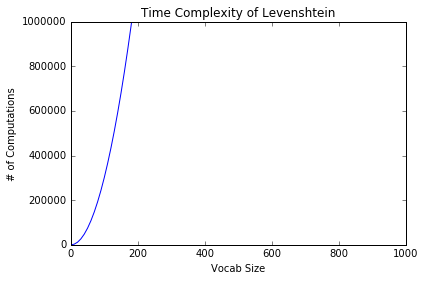

In [502]:
%%time
from functools import partial
import matplotlib.pyplot as plt
%matplotlib inline
vocab_size = range(0,1000,10)
avg_len_word = np.mean([len(w) for w in words]) # ~7.8
time_complexity = [partial(lv_time_complexity,vocab_size_i)(avg_len_word) 
                   for vocab_size_i in vocab_size]
plt.plot(vocab_size, time_complexity)
plt.ylim(0,1000000)
plt.xlabel('Vocab Size')
plt.ylabel('# of Computations')
plt.title('Time Complexity of Levenshtein')

# Auto Correction

In [582]:
from collections import Counter
from nltk import bigrams, trigrams

In [658]:
def load_brown():
    
    from nltk.corpus import brown
    print "... extracting words"
    words = [word.lower() for word in brown.words()]
    return (Counter(words), words)

In [854]:
%%time
brown_unigram_dict, brown_tokens = load_brown() # len: dict=49815, tokens=1161192.

... extracting words
CPU times: user 3.27 s, sys: 27.5 ms, total: 3.3 s
Wall time: 3.29 s


In [856]:
%%time
brown_bigram_dict = Counter(bigrams(brown_tokens))
brown_trigram_dict = Counter(trigrams(brown_tokens))

CPU times: user 2.44 s, sys: 78.7 ms, total: 2.52 s
Wall time: 2.5 s


In [857]:
from __future__ import division
from copy import deepcopy
count = lambda dic: sum(count for count in dic.values())
def conditional_prob(counter_dic, total_num):
    prob_dic = deepcopy(counter_dic)
    for key in prob_dic.keys():
        prob_dic[key] = prob_dic[key]/total_num
    return prob_dic

In [859]:
%%time
num_unigrams, num_bigrams, num_trigrams = count(brown_unigram_dict), \
                                          count(brown_bigram_dict), \
                                          count(brown_trigram_dict)
brown_unigram_prob_dict = conditional_prob(brown_unigram_dict,num_unigrams)
brown_bigram_prob_dict = conditional_prob(brown_bigram_dict,num_bigrams)
brown_trigram_prob_dict = conditional_prob(brown_trigram_dict,num_trigrams)

CPU times: user 11.5 s, sys: 285 ms, total: 11.8 s
Wall time: 11.7 s


In [885]:
class AutoCorrect: 
    # NB: spelling corrector by Peter Norvig, ngram spelling check by Jacob Su Wang.
    
    def __init__(self, token_counter, unigram_prob_dict, 
                                      bigram_prob_dict, 
                                      trigram_prob_dict):
        self.token_counter = token_counter
        self.unigram_prob_dict = unigram_prob_dict
        self.bigram_prob_dict = bigram_prob_dict
        self.trigram_prob_dict = trigram_prob_dict
        self.alphabet = 'abcdefghijklmnopqrstuvwxyz'
        return
    
    def edits1(self, word):
        splits     = [(word[:i], word[i:]) for i in range(len(word) + 1)]
        deletes    = [a + b[1:] for a, b in splits if b]
        transposes = [a + b[1] + b[0] + b[2:] for a, b in splits if len(b)>1]
        replaces   = [a + c + b[1:] for a, b in splits for c in self.alphabet if b]
        inserts    = [a + c + b     for a, b in splits for c in self.alphabet]
        return set(deletes + transposes + replaces + inserts)
    
    def known_edits2(self, word):
        return set(e2 for e1 in self.edits1(word) 
                      for e2 in self.edits1(e1) if e2 in self.token_counter)
    
    def known(self, words): 
        return set(w for w in words if w in self.token_counter)
    
    def get_n_grams(self, word_idx, sent):
        unigram = sent[word_idx]
        bigram = sent[max(0,word_idx-1):word_idx+1]
        trigram = sent[max(0,word_idx-2):word_idx+1]
        # pad '' when previous k words do not exist (e.g. sentence-initial).
        for i in xrange(2-len(bigram)): 
            bigram.insert(0,'')
        for i in xrange(3-len(trigram)):
            trigram.insert(0,'')
        return (unigram,tuple(bigram),tuple(trigram))

    def correct(self, word):
        candidates = self.known([word]) or \
                     self.known(self.edits1(word)) or \
                     self.known_edits2(word) or \
                     [word]
        return max(candidates, key=self.token_counter.get)
    
    def linear_interpolation(self, unigram, bigram, trigram, 
                                     lmds):
        prob = lmds[0] + lmds[1]*self.unigram_prob_dict[unigram] + \
                         lmds[2]*self.bigram_prob_dict[bigram] + \
                         lmds[3]*self.trigram_prob_dict[trigram]
        return prob       
    
    def spelling_check(self, sent, lmds=[.05,.15,.3,.5]):
        # lambda weights: UNK, unigram, bigram, trigram.
        corrected_sent = []
        for i,word in enumerate(sent):
            unigram,bigram,trigram = self.get_n_grams(i,sent)
            corrected = self.correct(word)
            cor_unigram,cor_bigram,cor_trigram = corrected, \
                                                 (bigram[0],corrected), \
                                                 (trigram[0],trigram[1],corrected)
            corrected_sent += [word] \
                              if self.linear_interpolation(unigram,bigram,trigram,lmds) > \
                                 self.linear_interpolation(cor_unigram,cor_bigram,cor_trigram,lmds) \
                              else [corrected]
        return corrected_sent


In [886]:
ac = AutoCorrect(brown_unigram_dict, brown_unigram_prob_dict, brown_bigram_prob_dict, brown_trigram_prob_dict)

In [887]:
sent = 'this iss a goood dai in austin'.split()
ac.spelling_check(sent)

['this', 'is', 'a', 'good', 'day', 'in', 'austin']

In [898]:
# IF 'is' is incorrectly corrected to 'si', 
#  linear interpolation saves the day:
print "Pr('si') = ", ac.linear_interpolation('si',('this','si'),('','this','si'),[.05,.15,.3,.5])
print "Pr('is) = ", ac.linear_interpolation('is',('this','is'),('','this','is'),[.05,.15,.3,.5])

Pr('si') =  0.0500001291776
Pr('is) =  0.051417724297
